# Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
# loading in Quora dataset
df = pd.read_csv('NLP-project/data/train.csv')

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

## Exploration

In [3]:
# print first 5 rows of dataset
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# get number of rows and columns in dataset
df.shape

(404290, 6)

In [5]:
# check
df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [6]:
# how many missing values?
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [7]:
# find the rows containing the missing values
df[df.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


We can see that there are 3 rows containing missing values, where rows 1 and 2 have very similar questions but have missing values under 'question2'. Row 3 is missing under 'question1' therefore since we only have 3 missing we can drop these rows and continue on.

In [8]:
# drop missing values from dataset
df = df.dropna()

In [9]:
# check missing values to see if they were dropped
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [10]:
# find number of duplicate and non-duplicate questions
df_dupes = df['is_duplicate'].value_counts() 
print(f"There are {df_dupes[0]} non-duplicate questions and {df_dupes[1]} duplicate questions.")

There are 255024 non-duplicate questions and 149263 duplicate questions.


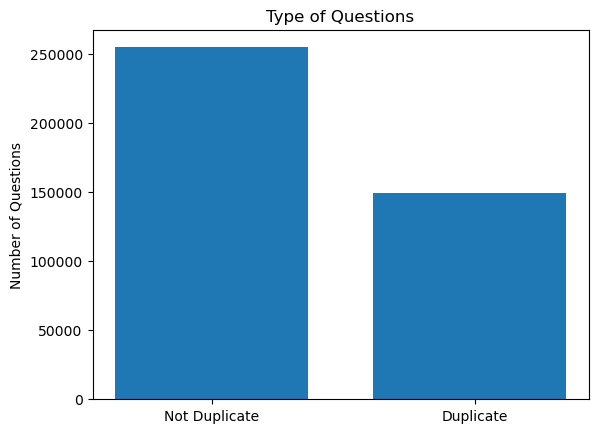

In [11]:
# plot number of duplicates and non-duplicate questions
plt.hist(df['is_duplicate'], bins=[0, 0.5, 1], align='mid', rwidth=0.75)
plt.title('Type of Questions')
plt.xticks([0.25, 0.76], ['Not Duplicate', 'Duplicate'])
plt.ylabel('Number of Questions')
plt.show()

In [12]:
# Check the duplicate counts in terms of each percentage ("question1" and "question2") from the total
df_dupes_per = df_dupes / len(df) * 100
print(f"Percantage of non-duplicates questions is {round(df_dupes_per[0], 2)}% and percentage of duplicates is {round(df_dupes_per[1], 2)}%")

Percantage of non-duplicates questions is 63.08% and percentage of duplicates is 36.92%


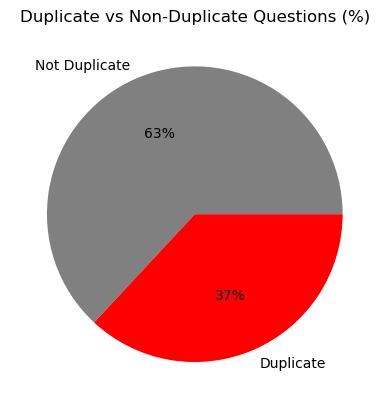

In [13]:
# Plot as a pie chart
plt.pie(df_dupes_per, labels=['Not Duplicate', 'Duplicate'], autopct='%1.0f%%', colors=['grey', 'red']) 
plt.title('Duplicate vs Non-Duplicate Questions (%)')
plt.show()

## Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [14]:
# importing and set up for cleaning function
import nltk
import re
import string

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Jagvir
[nltk_data]     Dhesi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Jagvir
[nltk_data]     Dhesi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
def preprocess_clean(text):
    # tokenize the text
    tokens = nltk.word_tokenize(text)

    # preprocess each token by iterating through each one 
    text = []
    for token in tokens:
        # convert to lowercase
        token = token.lower()
        # remove punctuation and digits
        token = re.sub(r'[^\w\s]', '', token)
        # remove non-alphabetic characters
        token = re.sub(r'[^a-zA-Z\s]', '', token)
        # stem the word
        token = stemmer.stem(token)
        # lemmatize the word
        token = lemmatizer.lemmatize(token)
        if token not in stop_words:
            text.append(token) # add the preprocessed tokens into the text list

    # join the words back into a string
    text_processed = ' '.join(text)

    return text_processed

In [16]:
# Apply preprocessing on question 1
df['question1_processed'] = df['question1'].apply(preprocess_clean)

In [17]:
# Apply preprocessing on question 2
df['question2_processed'] = df['question2'].apply(preprocess_clean)

In [18]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_processed,question2_processed
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guid invest share market india,step step guid invest share market
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor koh...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increas speed internet connect use vpn,internet speed increas hack dns
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,whi mental veri lone solv,find remaind math math divid
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolv water quik sugar salt methan car...,fish would surviv salt water


## Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

#### TF-IDF Vectorizer

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create a TfidfVectorizer object with some parameters
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features=1000)

# fit and transform the preprocessed text for both questions
tfidf_question1 = tfidf_vectorizer.fit_transform(df['question1_processed'])
tfidf_question2 = tfidf_vectorizer.fit_transform(df['question2_processed'])

In [20]:
# create pandas DataFrame from tfidf_vectorizer_data
tfidf_question1_df = pd.DataFrame(tfidf_question1.toarray())
tfidf_question2_df = pd.DataFrame(tfidf_question2.toarray())

In [21]:
# check dataframe
tfidf_question1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
tfidf_question2_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### word2vec

In [23]:
# imports
import gensim
from gensim.models import Word2Vec

In [24]:
# Concatenate the preprocessed text for both questions and split them into individual words.
all_questions = df['question1_processed'] + df['question2_processed']
all_words = [question.split() for question in all_questions]

In [25]:
# Train a Word2Vec model on the concatenated text.
model = Word2Vec(all_words, min_count=2)

In [26]:
# Create a dictionary with each unique word and its frequency in the concatenated text.
word_freq = {}
for words in all_words:
    for word in words:
        if word not in word_freq:
            word_freq[word] = 1
        else:
            word_freq[word] += 1

In [27]:
# Create a feature for each question that counts the number of unique words that appear more than twice
def count_unique_words(row):
    question = row['question1_processed'] + row['question2_processed']
    words = question.split()
    count = 0
    for word in set(words):
        if word_freq[word] > 2:
            count += 1
    return count

In [28]:
# create column in dataframe
df['unique_word_count'] = df.apply(count_unique_words, axis=1)

In [29]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_processed,question2_processed,unique_word_count
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guid invest share market india,step step guid invest share market,6
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor koh...,9
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increas speed internet connect use vpn,internet speed increas hack dns,8
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,whi mental veri lone solv,find remaind math math divid,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolv water quik sugar salt methan car...,fish would surviv salt water,13


#### Word Count

In [30]:
# import
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
# create a CountVectorizer object with some parameters
count_vectorizer = CountVectorizer()

In [32]:
# fit and transform the preprocessed text for both questions
count_question1 = count_vectorizer.fit_transform(df['question1_processed'])
count_question2 = count_vectorizer.fit_transform(df['question2_processed'])

In [33]:
print('vocabulary word count: ', count_vectorizer.vocabulary_)

vocabulary word count:  {'step': 42472, 'guid': 18174, 'invest': 21763, 'share': 40130, 'market': 26629, 'would': 49540, 'happen': 18623, 'indian': 21096, 'govern': 17739, 'stole': 42579, 'kohinoor': 23917, 'diamond': 11603, 'back': 3476, 'internet': 21625, 'speed': 41880, 'increas': 21032, 'hack': 18372, 'dns': 12156, 'find': 15432, 'remaind': 37279, 'math': 26838, 'divid': 12078, 'fish': 15539, 'surviv': 43386, 'salt': 38669, 'water': 48563, 'tripl': 45799, 'capricorn': 6688, 'sun': 43151, 'moon': 28550, 'ascend': 2693, 'doe': 12210, 'say': 39018, 'keep': 23363, 'childern': 7764, 'activ': 386, 'far': 14959, 'phone': 33689, 'video': 47886, 'game': 16711, 'great': 17904, 'geologist': 17066, 'use': 47261, 'instead': 21491, 'motorola': 28707, 'dcx': 10778, 'free': 16188, 'thing': 44706, 'technician': 44169, 'tell': 44266, 'durabl': 12831, 'reliabl': 37246, 'laptop': 24459, 'compon': 8947, 'see': 39548, 'youtub': 50257, 'comment': 8818, 'make': 26247, 'physic': 33788, 'easi': 13019, 'lear

#### Word Count Per Token

In [34]:
# add word count per row per token into dataframe as new column
df['question1_word_count'] = df['question1_processed'].str.split().apply(len)
df['question2_word_count'] = df['question2_processed'].str.split().apply(len)

In [35]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_processed,question2_processed,unique_word_count,question1_word_count,question2_word_count
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guid invest share market india,step step guid invest share market,6,7,6
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor koh...,9,4,9
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increas speed internet connect use vpn,internet speed increas hack dns,8,6,5
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,whi mental veri lone solv,find remaind math math divid,9,5,5
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolv water quik sugar salt methan car...,fish would surviv salt water,13,10,5


### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

#### Logistic Regression

In [36]:
# select features and target variable
X = df[['question1_processed', 'question2_processed', 'unique_word_count', 'question1_word_count', 'question2_word_count']]
y = df['is_duplicate']

In [37]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# transform 'question1_processed' and 'question2_processed' into vectors since they are strings
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1, 3), norm='l2')

X_train_question1_processed = vectorizer.fit_transform(X_train['question1_processed'])
X_train_question2_processed = vectorizer.transform(X_train['question2_processed']) 
X_test_question1_processed = vectorizer.transform(X_test['question1_processed']) 
X_test_question2_processed = vectorizer.transform(X_test['question2_processed']) 

In [39]:
# combine to original split data and make new variable as final train/test
# use tocsr() to compress data so it can be run and fit, aswell using .values() to have a numpy array
from scipy.sparse import hstack

X_train_final = hstack((X_train_question1_processed, X_train_question2_processed, X_train[['unique_word_count', 'question1_word_count', 'question2_word_count']].values)).tocsr()
X_test_final = hstack((X_test_question1_processed, X_test_question2_processed, X_test[['unique_word_count', 'question1_word_count', 'question2_word_count']].values)).tocsr()

In [40]:
# initialize logistic regression model as baseline model to compare to:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)

# fit model to training data
lr.fit(X_train_final, y_train)

C:\Users\Jagvir Dhesi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [41]:
# make predictions on test data
y_pred = lr.predict(X_test_final)

In [42]:
lr.score(X_test_final, y_test)

0.8073783670137772

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy Score = {}'.format(accuracy))

# precision score
precision = precision_score(y_test, y_pred)
print('Precision Score = {}'.format(precision))

# recall score
recall = recall_score(y_test, y_pred)
print('Recall Score = {}'.format(recall))

# f1 score
f1 = f1_score(y_test, y_pred)
print('F1 Score = {}'.format(f1))

Accuracy Score = 0.8073783670137772
Precision Score = 0.7472169238772325
Recall Score = 0.7222445695897023
F1 Score = 0.7345185538718529


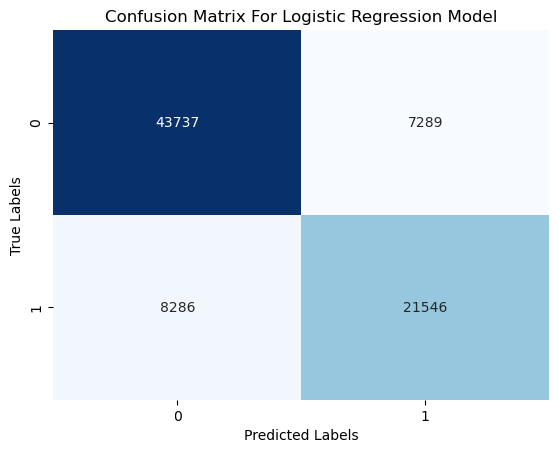

In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix For Logistic Regression Model")
plt.show()

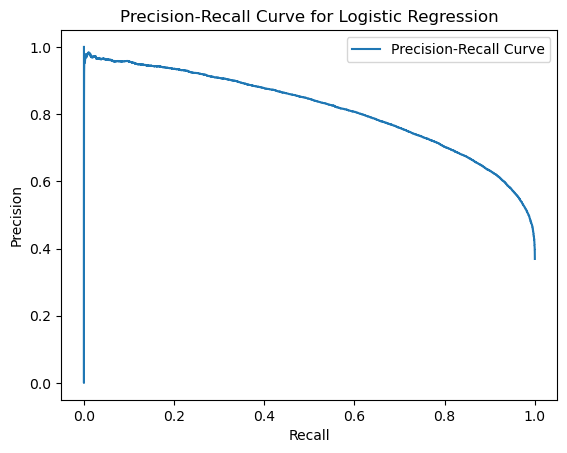

In [45]:
from sklearn.metrics import precision_recall_curve

# get predicted probabilities
y_prob = lr.predict_proba(X_test_final)[:, 1]

# calculate precision and recall values at various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# plot precision-recall curve
import matplotlib.pyplot as plt

plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend()
plt.show()

Try paramater grid search to improve the results

In [46]:
# from sklearn.model_selection import GridSearchCV

# # Define the hyperparameters to be tested
# param_grid = {'C': [0.01, 0.1, 1, 5, 10, 50, 100], # controls regularization strength (lower is stronger)
#               'penalty': ['11', 'l2']}

In [47]:
# # Create the GridSearchCV object with the specified hyperparameters and cross-validation
# grid_search = GridSearchCV(lr, param_grid, cv=2)

In [ ]:
# # Fit the grid search object to the training data
# grid_search.fit(X_train_final, y_train)

C:\Users\Jagvir Dhesi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Jagvir Dhesi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Jagvir Dhesi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C

In [ ]:
# # Print the best hyperparameters and the corresponding mean cross-validation score
# print("Best parameters: ", grid_search.best_params_)
# print("Best cross-validation score: ", grid_search.best_score_)

In [ ]:
# grid_lr_model = grid_search.best_params_
# grid_lr_model

#### XGBoost

In [ ]:
# # import XGBoost:
# import xgboost as xgb

# # convert data to DMatrix format
# dtrain = xgb.DMatrix(X_train_final, label=y_train)
# dtest = xgb.DMatrix(X_test_final, label=y_test)

# # set hyperparameters
# params = {
#     'max_depth': 3,
#     'eta': 0.1,
#     'objective': 'reg:squarederror'
# }

# # train the model
# num_rounds = 100
# xgb_model = xgb.train(params, dtrain, num_rounds)

# # make prediction on test data
# y_pred_xgboost = xgb_model.predict(dtest)

In [ ]:
# # evaluation of XGBoost model mse, mae, r2, and rmse:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# xgboost_mse = mean_squared_error(y_test, y_pred_xgboost)
# print('Mean Squared Error = {:.3f}.'.format(xgboost_mse))

# xgboost_mae = mean_absolute_error(y_test, y_pred_xgboost)
# print('Mean Absolute Error = {:.3f}.'.format(xgboost_mae))

# xgboost_r2 = r2_score(y_test, y_pred_xgboost)
# print('R2_score = {:.3f}.'.format(xgboost_r2))

# xgboost_rmse = np.sqrt(xgboost_mse)
# print('Root Mean Squared Error = {:.3f}.'.format(xgboost_rmse))